# NN on an Imbalance Dataset, trial 2

Instead of setting digit 0 and True and digits 1-9 as False, let's simply look at digits 1 vs 7, and how losing samples will impact the performance.

In [1]:
import time
import pandas as pd
import numpy as np
from numpy.random import uniform
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./.data/', one_hot=True)

Using TensorFlow backend.


Extracting ./.data/train-images-idx3-ubyte.gz
Extracting ./.data/train-labels-idx1-ubyte.gz
Extracting ./.data/t10k-images-idx3-ubyte.gz
Extracting ./.data/t10k-labels-idx1-ubyte.gz


In [2]:
X_train = mnist.train.images
X_test = mnist.test.images
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')/255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')/255

## 50% Positives

Since Keras's labels already come one-hot encoded, we have to do some manipulation to get this back to binary. Here, we chose 1 as 1 and 7 as 0.

In [3]:
y_actual = pd.DataFrame(mnist.train.labels).idxmax(1).values # this gets the actual integer values
print y_actual[:5] # for example

y_train_temp = [0 if y==7 else 1 if y==1 else 'drop' for y in y_actual] # label the records to drop
print y_train_temp[:5] # for example

# do the same with test dataset
y_actual = pd.DataFrame(mnist.test.labels).idxmax(1).values
y_test_temp = [0 if y==7 else 1 if y==1 else 'drop' for y in y_actual]

[7 3 4 6 1]
[0, 'drop', 'drop', 'drop', 1]


In [4]:
# make final y_train, y_test, X_train, and X_test arrays by dropping the records labeled 'drop'
y_train = np.array([y_train_temp[i] for i in range(len(y_train_temp)) if y_train_temp[i]!='drop'])
print y_train[:5]

y_test = np.array([y_test_temp[i] for i in range(len(y_test_temp)) if y_test_temp[i]!='drop'])

# keep a copy of X arrays since we're about to overwrite them
X_train_temp = X_train
X_test_temp = X_test

# iterate through to find y=='drop', and drop that record from X
X_train = np.array([X_train_temp[i] for i in range(len(X_train_temp)) if y_train_temp[i]!='drop'])
X_test = np.array([X_test_temp[i] for i in range(len(X_test_temp)) if y_test_temp[i]!='drop'])

[0 1 1 1 0]


In [5]:
# sanity checks
print len(X_train)
print len(X_test)
print len(y_train)
print len(y_test)

11894
2163
11894
2163


Lengths match, good.

In [6]:
# more sanity checks
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(11894, 1, 28, 28)
(2163, 1, 28, 28)
(11894,)
(2163,)


Shapes are correct, good.

In [7]:
# even more sanity checks
print pd.Series(y_train).value_counts()
print pd.Series(y_test).value_counts()

1    6179
0    5715
dtype: int64
1    1135
0    1028
dtype: int64


Proportions are solid, good.

### Train

In [8]:
model = Sequential()
model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(1,28,28), dim_ordering='th'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", data_format="channels_first", input_shape=(1, 28, 28...)`
  from ipykernel import kernelapp as app
/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu")`


In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy']) # may want to change this later, but this is the default so let's test this out

In [10]:
t0 = time.time()
model.fit(X_train, y_train,
          batch_size=50,
          nb_epoch=10
         )
print "training time = {}".format(time.time() - t0)

/usr/local/lib64/python2.7/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
11894/11894 [==============================] - 4s - loss: 0.6566 - acc: 0.5983       

### Evaluate

2144/2163 [============================>.] - ETA: 0s

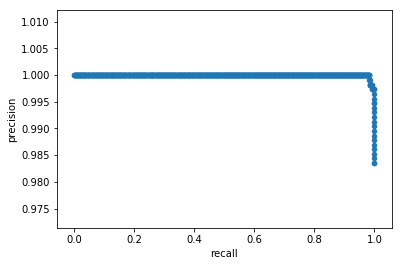

In [11]:
from sklearn.metrics import precision_recall_curve
%matplotlib inline

y_pred = model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

df_pr = pd.DataFrame({'recall':recall, 'precision':precision})

df_pr.plot.scatter('recall','precision')

In [12]:
from sklearn.metrics import confusion_matrix
thresh = 0.5 # arbitrary for this test

mat = confusion_matrix(y_test, [0 if y<0.5 else 1 for y in y_pred])

print mat

[[1016   12]
 [   1 1134]]


Looks like the classifier's doing fine so far. Let's take the positives down a notch and try again.

## 10% Positives

First we have to downsample both the X_train and associated y_train. We don't have to touch the X_test or y_test since we're testing the training capability of NNs. Plus this lets us test on the same dataset.

In [13]:
from numpy.random import uniform

In [14]:
d10 = uniform(0, 1, len(y_train)) # create a list of d10

In [15]:
y_train_1 = [] # 1%
for i in range(len(y_train)):
    if y_train[i]==0:
        y_train_1.append(y_train[i])
    elif y_train[i]==1 and d10[i]<0.1:
        y_train_1.append(y_train[i])

In [16]:
print "Length of new y array = "+str(len(y_train_1))
print pd.Series(y_train).value_counts()
print pd.Series(y_train_1).value_counts()

Length of new y array = 6315
1    6179
0    5715
dtype: int64
0    5715
1     600
dtype: int64


Looks like only 10% of the positives remain while all the negatives remain. Great! Let's apply this to the X_train now.

In [17]:
X_train_1 = [] # 1%
for i in range(len(X_train)):
    if y_train[i]==0:
        X_train_1.append(X_train[i])
    elif y_train[i]==1 and d10[i]<0.1:
        X_train_1.append(X_train[i])

In [18]:
len(X_train_1)

6315

Length of new X array checks out.

### Train

In [19]:
model = Sequential()
model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(1,28,28), dim_ordering='th'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", data_format="channels_first", input_shape=(1, 28, 28...)`
  from ipykernel import kernelapp as app
/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu")`


In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy']) # may want to change this later, but this is the default so let's test this out

In [21]:
t0 = time.time()
model.fit(X_train, y_train,
          batch_size=50,
          nb_epoch=10
         )
print "training time = {}".format(time.time() - t0)

Epoch 1/10
11894/11894 [==============================] - 3s - loss: 0.6682 - acc: 0.5795      

### Evaluate

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy']) # may want to change this later, but this is the default so let's test this out

2144/2163 [============================>.] - ETA: 0s

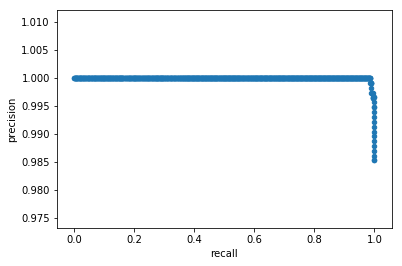

In [23]:
from sklearn.metrics import precision_recall_curve
%matplotlib inline

y_pred = model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

df_pr = pd.DataFrame({'recall':recall, 'precision':precision})

df_pr.plot.scatter('recall','precision')

In [24]:
from sklearn.metrics import confusion_matrix
thresh = 0.5 # arbitrary for this test

mat = confusion_matrix(y_test, [0 if y<0.5 else 1 for y in y_pred])

print mat

[[1009   19]
 [   0 1135]]


Still looks great when positives only make up 1% of the sample. Let's keep going!

## 1% Setup

We'll be using the same code as above, except this time we'll take even less of the positive dataset.

In [25]:
d10 = uniform(0, 1, len(y_train)) # create a list of d10

In [26]:
y_train_1 = [] # 1%
for i in range(len(y_train)):
    if y_train[i]==0:
        y_train_1.append(y_train[i])
    elif y_train[i]==1 and d10[i]<0.01: # this value was brought even lower
        y_train_1.append(y_train[i])

In [27]:
print "Length of new y array = "+str(len(y_train_1))
print pd.Series(y_train).value_counts()
print pd.Series(y_train_1).value_counts()

Length of new y array = 5781
1    6179
0    5715
dtype: int64
0    5715
1      66
dtype: int64


Looks like only 1% of the positives remain while all the negatives remain. Great! Let's apply this to the X_train now. Not doing too great from a sample size standpoint :\ but maybe it'll still learn.

In [28]:
X_train_1 = [] # 1%
for i in range(len(X_train)):
    if y_train[i]==0:
        X_train_1.append(X_train[i])
    elif y_train[i]==1 and d10[i]<0.01:
        X_train_1.append(X_train[i])

In [29]:
len(X_train_1)

5781

Length of new X array checks out.

### Train

In [30]:
model = Sequential()
model.add(Convolution2D(32, 5, 5, activation='relu', input_shape=(1,28,28), dim_ordering='th'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", data_format="channels_first", input_shape=(1, 28, 28...)`
  from ipykernel import kernelapp as app
/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu")`


In [31]:
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy']) # may want to change this later, but this is the default so let's test this out

In [32]:
t0 = time.time()
model.fit(X_train, y_train,
          batch_size=50,
          nb_epoch=10
         )
print "training time = {}".format(time.time() - t0)

Epoch 1/10
11894/11894 [==============================] - 3s - loss: 0.6431 - acc: 0.6088      

### Evaluate

2144/2163 [============================>.] - ETA: 0s

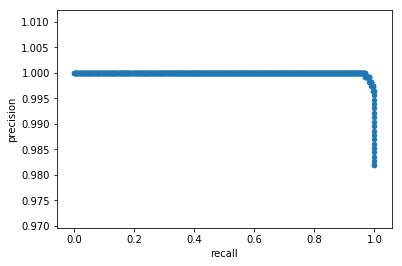

In [33]:
from sklearn.metrics import precision_recall_curve
%matplotlib inline

y_pred = model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

df_pr = pd.DataFrame({'recall':recall, 'precision':precision})

df_pr.plot.scatter('recall','precision')

In [34]:
from sklearn.metrics import confusion_matrix
thresh = 0.5 # arbitrary for this test

mat = confusion_matrix(y_test, [0 if y<0.5 else 1 for y in y_pred])

print mat

[[1011   17]
 [   1 1134]]


Still great. Looks like undersampling isn't an issue?